# Group Project Part 2: Data Exploration

In [1]:
import os
import csv 

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession

Matplotlib created a temporary cache directory at /scratch/ialtamirano/job_39289522/matplotlib-ehq5g1uy because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Evaluating the Data

---

### Dataset Overview
Name: WESAD (Wearable Stress and Affect Detection)

Link: https://ubi29.informatik.uni-siegen.de/usi/data_wesad.html

Citation: Philip Schmidt, Attila Reiss, Robert Duerichen, Claus Marberger and Kristof Van Laerhoven, "Introducing WESAD, a multimodal dataset for Wearable Stress and Affect Detection", ICMI 2018, Boulder, USA, 2018.

Devices:
- RespiBAN (worn on chest): ECG, EDA, EMG, RESP, TEMP, ACC
- Empatica E4 (worn on wrist): BVP, EDA, TEMP, ACC <br>

---

### Subjects and Observations
Subjects: 15 total (S2 to S17, excluding S12)

Observation Count:

- Each subject has ~2–3 million time points
- Total labeled observations across dataset: 60,807,600 <br>



In [2]:
#Total Number of Observations:

base_path = "../raw_data/WESAD"

# List of subject IDs in WESAD dataset (S12 is missing)
subject_ids = [f"S{i}" for i in range(2, 18) if i != 12]

total_observations = 0
subject_lengths = {}

# Loop through each subject's .pkl file
for subject in subject_ids:
    file_path = os.path.join(base_path, subject, f"{subject}.pkl")
    with open(file_path, "rb") as f:
        data = pickle.load(f, encoding="latin1")
        num_obs = len(data['label'])
        subject_lengths[subject] = num_obs
        total_observations += num_obs

print("Number of observations per subject:")
for subject, count in subject_lengths.items():
    print(f"  {subject}: {count}")

print(f"\nTotal number of labeled observations in the entire dataset: {total_observations}")


Number of observations per subject:
  S2: 4255300
  S3: 4545100
  S4: 4496100
  S5: 4380600
  S6: 4949700
  S7: 3666600
  S8: 3826200
  S9: 3656100
  S10: 3847200
  S11: 3663100
  S13: 3875900
  S14: 3883600
  S15: 3676400
  S16: 3941700
  S17: 4144000

Total number of labeled observations in the entire dataset: 60807600


In [3]:
#Total Observations per Label:

np.unique(data['label'], return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([1917301,  826700,  506100,  260400,  511700,   40600,   41299,
          39900]))

In [4]:
#missing data?

missing_counts = {}

# Loop through chest sensors
for sensor, values in data['signal']['chest'].items():
    missing = np.isnan(values).sum()
    missing_counts[f"chest_{sensor}"] = missing

# Loop through wrist sensors
for sensor, values in data['signal']['wrist'].items():
    missing = np.isnan(values).sum()
    missing_counts[f"wrist_{sensor}"] = missing

# Check labels
missing_counts['label'] = np.isnan(data['label']).sum()

for sensor, count in missing_counts.items():
    print(f"{sensor}: {count} missing values")

chest_ACC: 0 missing values
chest_ECG: 0 missing values
chest_EMG: 0 missing values
chest_EDA: 0 missing values
chest_Temp: 0 missing values
chest_Resp: 0 missing values
wrist_ACC: 0 missing values
wrist_BVP: 0 missing values
wrist_EDA: 0 missing values
wrist_TEMP: 0 missing values
label: 0 missing values


### review subject s2 as an example

In [5]:
# # observations for a single Subject S2:

with open("../raw_data/WESAD/S2/S2.pkl", "rb") as f:
    data = pickle.load(f, encoding="latin1")

total_labels = len(data['label'])

# Count number of observations for each sensor
print(f"Total labeled observations: {total_labels}")

print("\nChest Sensors:")
for sensor, values in data['signal']['chest'].items():
    print(f"  {sensor}: {values.shape}")

print("\nWrist Sensors:")
for sensor, values in data['signal']['wrist'].items():
    print(f"  {sensor}: {values.shape}")

#The rest of this file will include examples from subject 2...

Total labeled observations: 4255300

Chest Sensors:
  ACC: (4255300, 3)
  ECG: (4255300, 1)
  EMG: (4255300, 1)
  EDA: (4255300, 1)
  Temp: (4255300, 1)
  Resp: (4255300, 1)

Wrist Sensors:
  ACC: (194528, 3)
  BVP: (389056, 1)
  EDA: (24316, 1)
  TEMP: (24316, 1)


In [6]:
#pkl files keys
print(data.keys())  #'signal', 'label', 'subject'

dict_keys(['signal', 'label', 'subject'])


In [7]:
#2 devices signal 
data['signal'].keys()

dict_keys(['chest', 'wrist'])

In [8]:
# signal types for each device:
print(data['signal']['chest'].keys())  # modalities like ECG, EMG, etc.
print(data['signal']['wrist'].keys())  # modalities like BVP, EDA, etc.

dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])


In [9]:
# # of observations for each label:
np.unique(data['label'], return_counts=True)

(array([0, 1, 2, 3, 4, 6, 7], dtype=int32),
 array([2142701,  800800,  430500,  253400,  537599,   45500,   44800]))

In [10]:
#Example pkl file:

# top 5 rows of chest and wrist data
chest_data = data['signal']['chest']
wrist_data = data['signal']['wrist']

for sensor in chest_data:
    print(f"\n=== Chest Sensor: {sensor} ===")
    display(pd.DataFrame(chest_data[sensor][:5]))

for sensor in wrist_data:
    print(f"\n=== Wrist Sensor: {sensor} ===")
    display(pd.DataFrame(wrist_data[sensor][:5]))


=== Chest Sensor: ACC ===


,0,1,2
0,0.9554,-0.2220,-0.5580
1,0.9258,-0.2216,-0.5538
2,0.9082,-0.2196,-0.5392
3,0.8974,-0.2102,-0.5122
4,0.8882,-0.2036,-0.4824



=== Chest Sensor: ECG ===


,0
0,0.021423
1,0.020325
2,0.016525
3,0.016708
4,0.011673



=== Chest Sensor: EMG ===


,0
0,-0.004440
1,0.004349
2,0.005173
3,0.007187
4,-0.015152



=== Chest Sensor: EDA ===


,0
0,5.250549
1,5.267334
2,5.243301
3,5.249405
4,5.286407



=== Chest Sensor: Temp ===


,0
0,30.120758
1,30.129517
2,30.138214
3,30.129517
4,30.130951



=== Chest Sensor: Resp ===


,0
0,-1.148987
1,-1.124573
2,-1.152039
3,-1.158142
4,-1.161194



=== Wrist Sensor: ACC ===


,0,1,2
0,62.0,-21.0,107.0
1,66.0,13.0,53.0
2,41.0,9.0,15.0
3,52.0,16.0,24.0
4,54.0,15.0,34.0



=== Wrist Sensor: BVP ===


,0
0,-59.37
1,-53.42
2,-44.40
3,-33.17
4,-20.79



=== Wrist Sensor: EDA ===


,0
0,1.138257
1,1.125444
2,1.011405
3,1.033188
4,0.935807



=== Wrist Sensor: TEMP ===


,0
0,35.41
1,35.41
2,35.41
3,35.41
4,35.41


In [11]:
# Labels:
data['label']

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [12]:
# label counts for S2:
labels, counts = np.unique(data['label'], return_counts=True)

label_names = {
    0: "Undefined",
    1: "Baseline",
    2: "Stress",
    3: "Amusement",
    4: "Meditation",
    5: "Ignore",
    6: "Ignore",
    7: "Ignore"
}

for l, c in zip(labels, counts):
    label = label_names.get(l, "Unknown")
    print(f"Label {l} ({label}): {c} samples")

Label 0 (Undefined): 2142701 samples
Label 1 (Baseline): 800800 samples
Label 2 (Stress): 430500 samples
Label 3 (Amusement): 253400 samples
Label 4 (Meditation): 537599 samples
Label 6 (Ignore): 45500 samples
Label 7 (Ignore): 44800 samples


# Plots

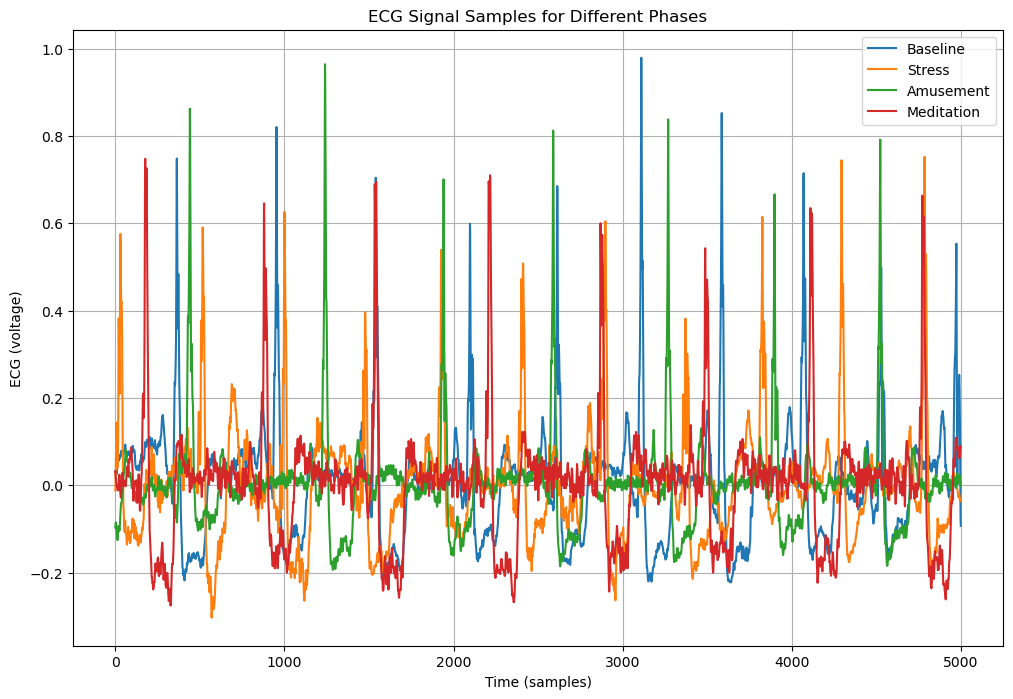

In [13]:
# ECG Signal During Each Phase

# load ECG 
ecg = data['signal']['chest']['ECG']
labels = data['label']

# phase names based on data 
label_names = {1: 'Baseline', 2: 'Stress', 3: 'Amusement', 4: 'Meditation'}

# plot segment for each label
plt.figure(figsize=(12, 8))
for lbl in [1, 2, 3, 4]:
    idx = np.where(labels == lbl)[0]
    if len(idx) > 0:
        segment = ecg[idx[0]:idx[0]+5000]
        plt.plot(segment, label=label_names[lbl])

plt.title("ECG Signal Samples for Different Phases")
plt.xlabel("Time (samples)")
plt.ylabel("ECG (voltage)")
plt.legend()
plt.grid(True)
plt.show()


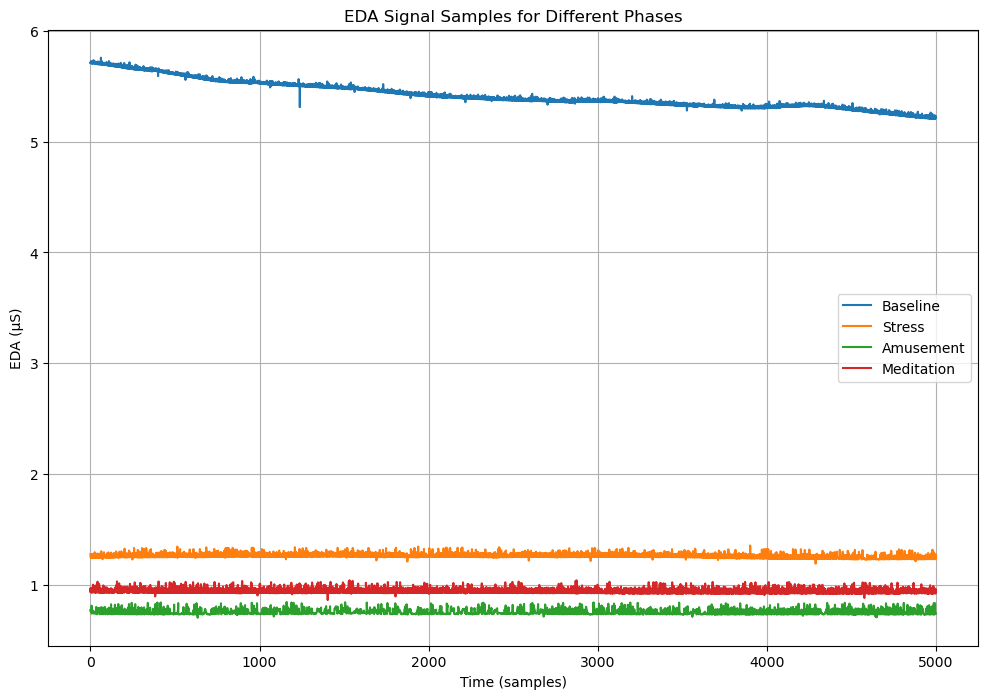

In [14]:
#EDA Signal by Label

eda = data['signal']['chest']['EDA']
labels = data['label']
label_names = {1: 'Baseline', 2: 'Stress', 3: 'Amusement', 4: 'Meditation'}

plt.figure(figsize=(12, 8))

for lbl in [1, 2, 3, 4]:
    idx = np.where(labels == lbl)[0]
    if len(idx) > 0:
        segment = eda[idx[0]:idx[0]+5000]
        plt.plot(segment, label=label_names[lbl])

plt.title("EDA Signal Samples for Different Phases")
plt.xlabel("Time (samples)")
plt.ylabel("EDA (µS)")
plt.legend()
plt.grid(True)
plt.show()


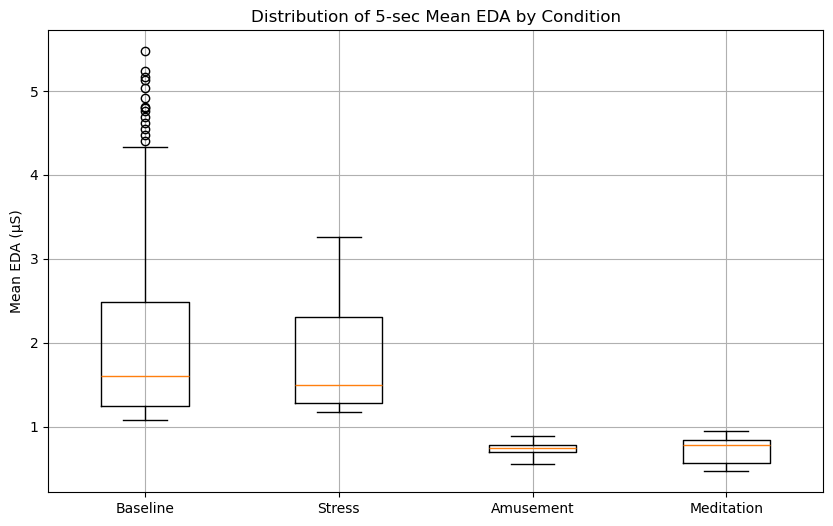

In [15]:
# Boxplot of Mean EDA by Label

# Get EDA signal and labels
eda = data['signal']['chest']['EDA']
labels = data['label']
label_names = {1: 'Baseline', 2: 'Stress', 3: 'Amusement', 4: 'Meditation'}

#  mean EDA values in short windows 5-sec segments
sampling_rate = 700
window_size = 5 * sampling_rate

eda_means_by_label = {1: [], 2: [], 3: [], 4: []}

for lbl in eda_means_by_label.keys():
    idx = np.where(labels == lbl)[0]
    # Slide through the signal in 5-second chunks
    for i in range(0, len(idx) - window_size, window_size):
        segment = eda[idx[i]:idx[i + window_size]]
        if len(segment) == window_size:
            eda_means_by_label[lbl].append(np.mean(segment))


data_to_plot = [eda_means_by_label[lbl] for lbl in [1, 2, 3, 4]]

plt.figure(figsize=(10, 6))
plt.boxplot(data_to_plot, labels=[label_names[lbl] for lbl in [1, 2, 3, 4]])
plt.title("Distribution of 5-sec Mean EDA by Condition")
plt.ylabel("Mean EDA (µS)")
plt.grid(True)
plt.show()


In [16]:
#Wrist BVP for each label
# Downsample labels to matching BVP length
factor = int(len(data['label']) / len(data['signal']['wrist']['BVP']))
labels_downsampled = data['label'][:factor * len(data['signal']['wrist']['BVP'])].reshape(-1, factor)
labels_bvp = mode(labels_downsampled, axis=1).mode.flatten()

bvp = data['signal']['wrist']['BVP']
label_names = {1: 'Baseline', 2: 'Stress', 3: 'Amusement', 4: 'Meditation'}

plt.figure(figsize=(12, 8))

for lbl in [1, 2, 3, 4]:
    idx = np.where(labels_bvp == lbl)[0]
    if len(idx) > 500:
        segment = bvp[idx[0]:idx[0] + 500]
        plt.plot(segment, label=label_names[lbl])

plt.title("Wrist BVP Signal for Each Condition")
plt.xlabel("Time (samples)")
plt.ylabel("BVP (raw units)")
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'mode' is not defined

In [ ]:
# compare chest respiration signal- Stress vs. Meditation
resp = data['signal']['chest']['Resp']
labels = data['label']
label_names = {2: 'Stress', 4: 'Meditation'}

plt.figure(figsize=(12, 6))

for lbl in [2, 4]:
    idx = np.where(labels == lbl)[0]
    if len(idx) > 2000:
        segment = resp[idx[0]:idx[0] + 2000]
        plt.plot(segment, label=label_names[lbl])

plt.title("Chest Respiration Signal: Stress vs. Meditation")
plt.xlabel("Time (samples)")
plt.ylabel("Resp (a.u.)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# TEMP signal from chest & corresponding labels
temp = data['signal']['chest']['Temp']
labels = data['label']
label_names = {1: 'Baseline', 2: 'Stress', 3: 'Amusement', 4: 'Meditation'}

# Avg temp in 10-sec windows
sampling_rate = 700
window_size = 10 * sampling_rate

temp_means_by_label = {1: [], 2: [], 3: [], 4: []}

for lbl in temp_means_by_label:
    idx = np.where(labels == lbl)[0]
    for i in range(0, len(idx) - window_size, window_size):
        segment = temp[idx[i]:idx[i + window_size]]
        if len(segment) == window_size:
            temp_means_by_label[lbl].append(np.mean(segment))

data_to_plot = [temp_means_by_label[lbl] for lbl in [1, 2, 3, 4]]

plt.figure(figsize=(10, 6))
plt.boxplot(data_to_plot, labels=[label_names[lbl] for lbl in [1, 2, 3, 4]])
plt.title("Chest Skin Temperature (10s Windows) by Condition")
plt.ylabel("Mean Temperature (°C)")
plt.grid(True)
plt.show()


In [ ]:


# label mapping
labels = data['label']
label_names = {1: 'Baseline', 2: 'Stress', 3: 'Amusement', 4: 'Meditation'}

# downsample labels to match wrist signal length
wrist_signals = data['signal']['wrist']
wrist_len = len(next(iter(wrist_signals.values())))
factor = int(len(labels) / wrist_len)

labels_downsampled = labels[:factor * wrist_len].reshape(-1, factor)
labels_wrist = mode(labels_downsampled, axis=1).mode.flatten()

#  plot fcn
def plot_signal_by_label(signal, labels, modality, location, is_multichannel=False, axes=None, window=1000):
    plt.figure(figsize=(12, 6))
    for lbl in [1, 2, 3, 4]:
        idx = np.where(labels == lbl)[0]
        if len(idx) > window:
            segment = signal[idx[0]:idx[0] + window]
            if is_multichannel:
                for i, axis in enumerate(axes):
                    plt.plot(segment[:, i], label=f'{label_names[lbl]} - {axis}')
            else:
                plt.plot(segment, label=label_names[lbl])
    plt.title(f"{location.upper()} - {modality} Signal by Label")
    plt.xlabel("Time (samples)")
    plt.ylabel(modality)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# CHEST Signals
plot_signal_by_label(data['signal']['chest']['ACC'], labels, "ACC (g)", "chest", is_multichannel=True, axes=['X', 'Y', 'Z'])
plot_signal_by_label(data['signal']['chest']['ECG'], labels, "ECG (voltage)", "chest")
plot_signal_by_label(data['signal']['chest']['EMG'], labels, "EMG (mV)", "chest")
plot_signal_by_label(data['signal']['chest']['EDA'], labels, "EDA (µS)", "chest")
plot_signal_by_label(data['signal']['chest']['Temp'], labels, "Temperature (°C)", "chest")
plot_signal_by_label(data['signal']['chest']['Resp'], labels, "Respiration (a.u.)", "chest")

# WRIST Signals (smaller window bc slower sampling rate)
plot_signal_by_label(data['signal']['wrist']['ACC'], labels_wrist, "ACC (g)", "wrist", is_multichannel=True, axes=['X', 'Y', 'Z'], window=200)
plot_signal_by_label(data['signal']['wrist']['BVP'], labels_wrist, "BVP", "wrist", window=200)
plot_signal_by_label(data['signal']['wrist']['EDA'], labels_wrist, "EDA (µS)", "wrist", window=200)
plot_signal_by_label(data['signal']['wrist']['TEMP'], labels_wrist, "Temperature (°C)", "wrist", window=200)


In [ ]:
#Let's compare EDA and Resp for possible correlation between each metric, first 5k samples, too large to acually display each one 
import seaborn as sns
df = pd.DataFrame({
    'EDA': data['signal']['chest']['EDA'].flatten(),
    'Resp': data['signal']['chest']['Resp'].flatten(),
    'Label': data['label']
})

sample_df = df[df['Label'].isin([1, 2, 3, 4])].sample(5000, random_state=42)

sns.pairplot(sample_df, hue='Label', vars=['EDA', 'Resp'], palette='Set2')
plt.suptitle("Signal Relationships (Sampled)", y=1.02)
plt.show()

## Preprocessing data 

In [ ]:
# copy this if not already previously defined
#This starts the spark session to be able to run the longer code below
sc = SparkSession.builder \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .config('spark.executor.instances', 7) \
    .getOrCreate()

In [ ]:

#Copy this into notebook
#Function defined to create summary statistics for the final notebook 
#The window sizes can be adjusted, but this is a great baseline to work with to match labels to sensor data

from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType
from pyspark.sql import Row
from scipy.stats import mode


# Function to compute stats with labels for windowed data
def compute_stats_with_labels(data, labels, window_size=700):
    # Ensure the data and labels are aligned
    num_windows = len(data) // window_size
    data = data[:num_windows * window_size]
    labels = labels[:num_windows * window_size]
    
    # Reshape data into windows
    reshaped_data = data.reshape(num_windows, window_size)
    reshaped_labels = labels.reshape(num_windows, window_size)
    
    # Compute statss
    stats = np.column_stack([
        reshaped_data.mean(axis=1),  # Mean
        reshaped_data.std(axis=1),   # Std
        reshaped_data.min(axis=1),   # Min
        reshaped_data.max(axis=1)    # Max
    ])
    
    # Get majority label for each window
    majority_labels = mode(reshaped_labels, axis=1).mode.flatten()
    
    return stats, majority_labels

# Function to extract EDA features and convert to PySpark DataFrame
def extract_eda_features_to_spark_df(subject_id, base_path, window_size=700):
    file_path = os.path.join(base_path, subject_id, f"{subject_id}.pkl")
    
    with open(file_path, "rb") as f:
        data = pickle.load(f, encoding="latin1")

    # Extract chest and wrist data
    chest = data['signal']['chest']
    wrist = data['signal']['wrist']
    
    # Extract labels
    labels = data['label']
    
    # For chest signals (e.g., ACC)
    chest_eda = chest['EDA'].flatten()  # Flatten to 1D
    chest_features, chest_labels = compute_stats_with_labels(chest_eda, labels, window_size)
    
    # For wrist signals (e.g., EDA)
    wrist_eda = wrist['EDA'].flatten()  # Flatten to 1D
    wrist_features, wrist_labels = compute_stats_with_labels(wrist_eda, labels, window_size)
    
    # Combine features from both chest and wrist (EDA) signals
    chest_rows = [
        Row(subject_id=subject_id, mean=float(mean), std=float(std), min_=float(min_), max_=float(max_), label=int(label))
        for mean, std, min_, max_, label in zip(chest_features[:, 0], chest_features[:, 1], 
                                                 chest_features[:, 2], chest_features[:, 3], chest_labels)
    ]
    
    wrist_rows = [
        Row(subject_id=subject_id, mean=float(mean), std=float(std), min_=float(min_), max_=float(max_), label=int(label))
        for mean, std, min_, max_, label in zip(wrist_features[:, 0], wrist_features[:, 1], 
                                                 wrist_features[:, 2], wrist_features[:, 3], wrist_labels)
    ]
    
    # Define schema explicitly for PySpark DataFrame
    schema = StructType([
        StructField("subject_id", StringType(), True),
        StructField("mean", FloatType(), True),
        StructField("std", FloatType(), True),
        StructField("min", FloatType(), True),
        StructField("max", FloatType(), True),
        StructField("label", IntegerType(), True)
    ])
    
    # Create DataFrame from the rows and schema
    chest_df = sc.createDataFrame(chest_rows, schema=schema)
    wrist_df = sc.createDataFrame(wrist_rows, schema=schema)
    
    # Combine chest and wrist DataFrames
    final_df = chest_df.union(wrist_df)
    
    return final_df


In [ ]:

#All subjects into one dataframe

# Initialize an empty DataFrame with the same schema as the first one
df_all = None

for i in range(2, 17):  # From S2 to S17
    if i == 12:
        continue  # Skip S12
    subject_id = f"S{i}"
    df = extract_eda_features_to_spark_df(subject_id, base_path)
    if df_all is None:
        df_all = df
    else:
        df_all = df_all.unionByName(df)


df_all.show(truncate=False)


df_all.groupBy("label").count().show()

# Check the length of the combined DataFrame
print(f"Combined DataFrame length: {df_all.count()}")

In [ ]:

#copy this to see breakdown of subjects
df_all.groupBy("subject_id").count().show()